In [1]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from typing import List, Any
import os
import pandas as pd

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings18 = sgl.ProcessorSGLSettings.from_range("20181201", "20190331")
sgl.initialize(settings18)
metas18 = sgl.get_metadata_from_csv(settings18.season_folder, ["tile-181", "tile-182", "tile-183"])
coll18 = sgl.create_collection_from_meta(settings18, metas18)

settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

settings20 = sgl.ProcessorSGLSettings.from_range("20201201", "20210331")
sgl.initialize(settings20)
metas20 = sgl.get_metadata_from_csv(settings20.season_folder, ["tile-181", "tile-182", "tile-183"])
coll20 = sgl.create_collection_from_meta(settings20, metas20)

X=====================================================
SGLProcessor started for 20181201 to 20190331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.
X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.
X=====================================================
SGLProcessor started for 20201201 to 20210331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 62 windows created for collection.


In [3]:
lakeextent18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_lakeextent.shp"))
drains18 = gpd.read_file(os.path.join(settings18.season_folder, "L8S2_20181201_20190331_drain.shp"))
#drains18.to_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
gdf_labels18 = pd.read_excel(os.path.join(settings18.season_folder, "drain_labels_v1.xlsx"))
drain_labels18 = dict(zip(gdf_labels18[gdf_labels18["window"] == 0]["criteria"], gdf_labels18[gdf_labels18["window"] == 0]["drainage"]))
positive_drains18 = [k for k, v in drain_labels18.items() if v == 1]
crevs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "crev_20181201_20190331_active_45(15).shp"))
dmgs18 = gpd.read_file(os.path.join(settings18.dmg_folder, "S1_20181201_20190331_dmg_5.shp"))

In [4]:
lakeextent19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_lakeextent.shp"))
drains19 = gpd.read_file(os.path.join(settings19.season_folder, "L8S2_20191201_20200331_drain.shp"))
#drains19.to_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
gdf_labels19 = pd.read_excel(os.path.join(settings19.season_folder, "drain_labels_v1.xlsx"))
drain_labels19 = dict(zip(gdf_labels19[gdf_labels19["window"] == 0]["criteria"], gdf_labels19[gdf_labels19["window"] == 0]["drainage"]))
positive_drains19 = [k for k, v in drain_labels19.items() if v == 1]
crevs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "crev_20191201_20200331_active_45(15).shp"))
dmgs19 = gpd.read_file(os.path.join(settings19.dmg_folder, "S1_20191201_20200331_dmg_5.shp"))

In [5]:
lakeextent20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_lakeextent.shp"))
drains20 = gpd.read_file(os.path.join(settings20.season_folder, "L8S2_20201201_20210331_drain.shp"))
#drains20.to_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
gdf_labels20 = pd.read_excel(os.path.join(settings20.season_folder, "drain_labels_v1.xlsx"))
drain_labels20 = dict(zip(gdf_labels20[gdf_labels20["window"] == 0]["criteria"], gdf_labels20[gdf_labels20["window"] == 0]["drainage"]))
positive_drains20 = [k for k, v in drain_labels20.items() if v == 1]
crevs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "crev_20201201_20210331_active_45(15).shp"))
dmgs20 = gpd.read_file(os.path.join(settings20.dmg_folder, "S1_20201201_20210331_dmg_5.shp"))

In [6]:
def set_share_axes(axs, target=None, sharex=False, sharey=False):
    if target is None:
        target = axs.flat[0]
    # Manage share using grouper objects
    for ax in axs.flat:
        if sharex:
            target._shared_axes['x'].join(target, ax)
        if sharey:
            target._shared_axes['y'].join(target, ax)
    # Turn off x tick labels and offset text for all but the bottom row
    if sharex and axs.ndim > 1:
        for ax in axs[:-1,:].flat:
            ax.xaxis.set_tick_params(which='both', labelbottom=False, labeltop=False)
            ax.xaxis.offsetText.set_visible(False)
    # Turn off y tick labels and offset text for all but the left most column
    if sharey and axs.ndim > 1:
        for ax in axs[:,1:].flat:
            ax.yaxis.set_tick_params(which='both', labelleft=False, labelright=False)
            ax.yaxis.offsetText.set_visible(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


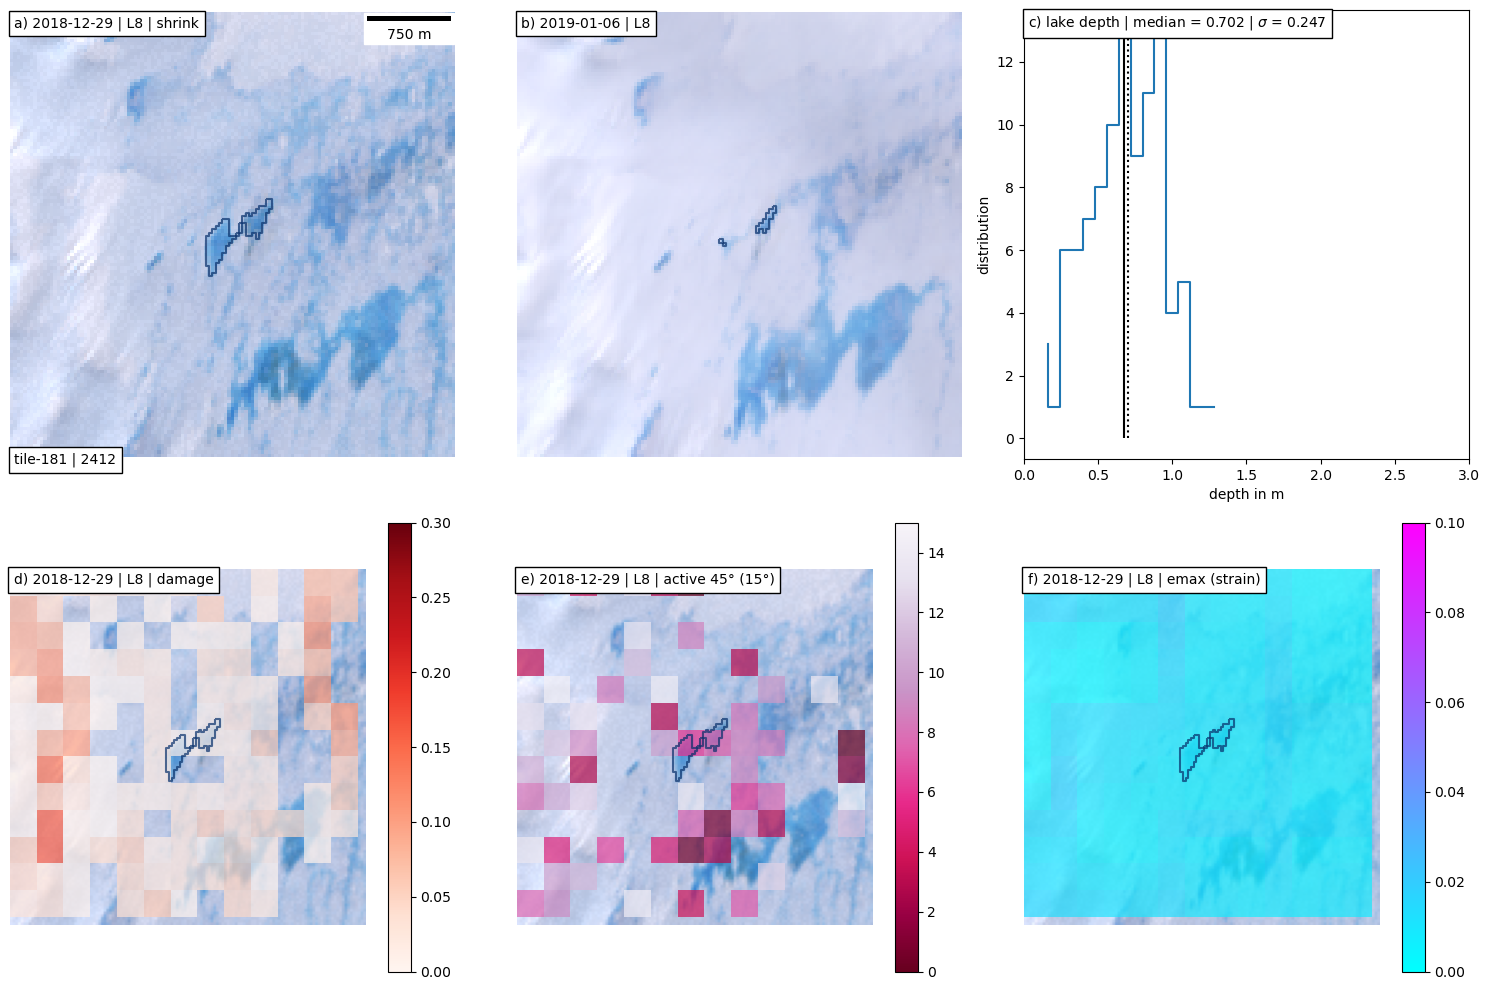

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


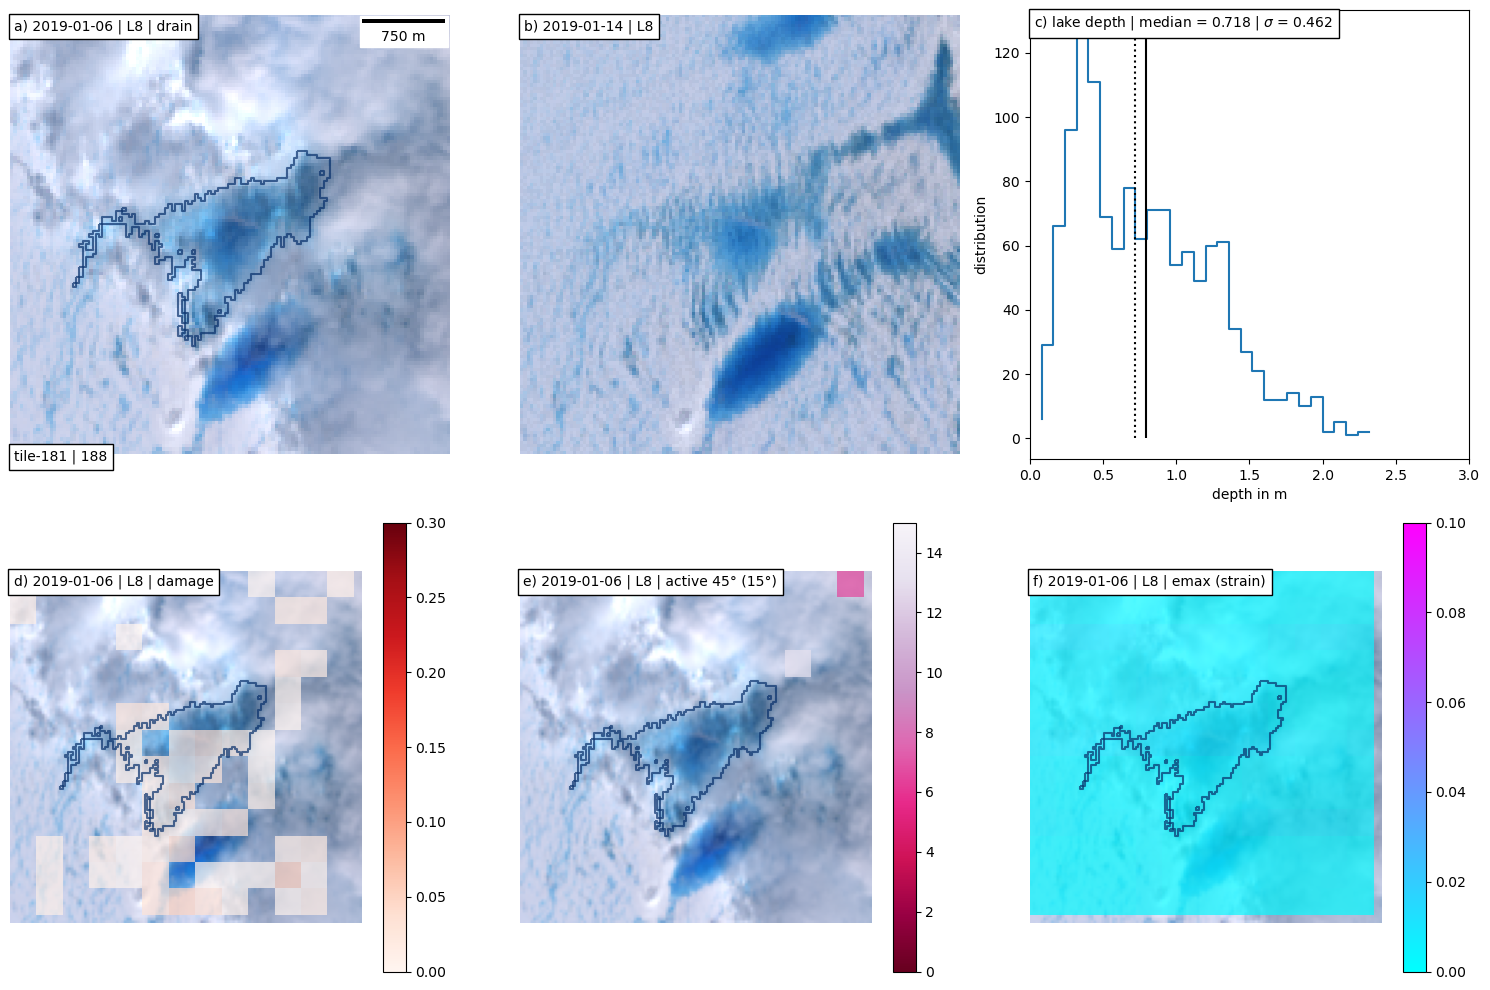

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


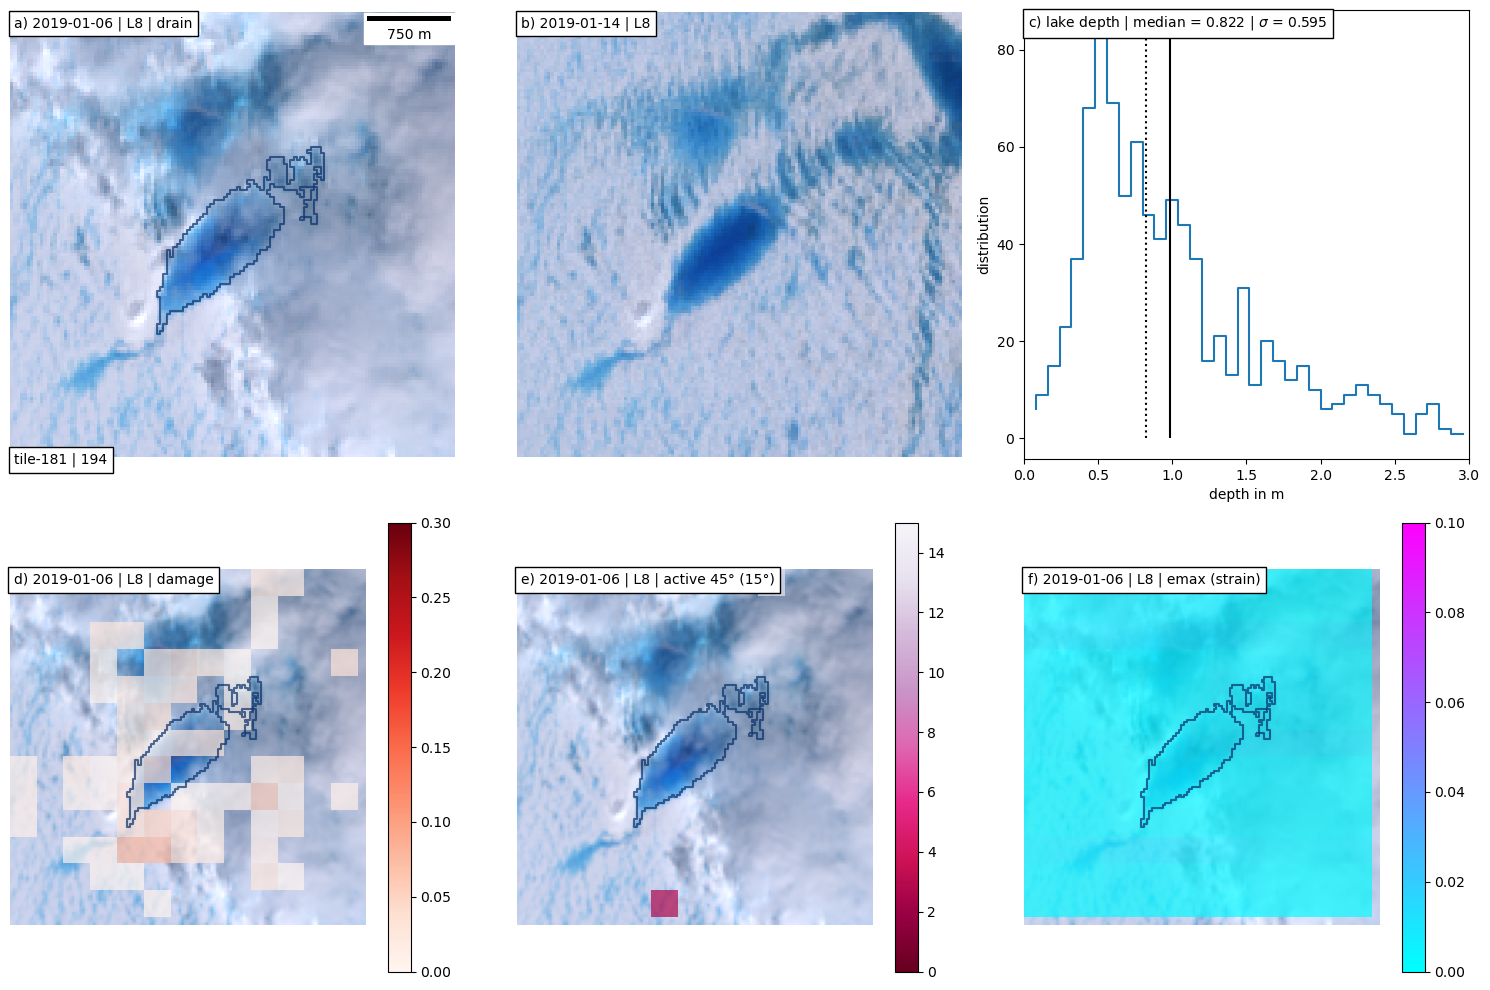

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


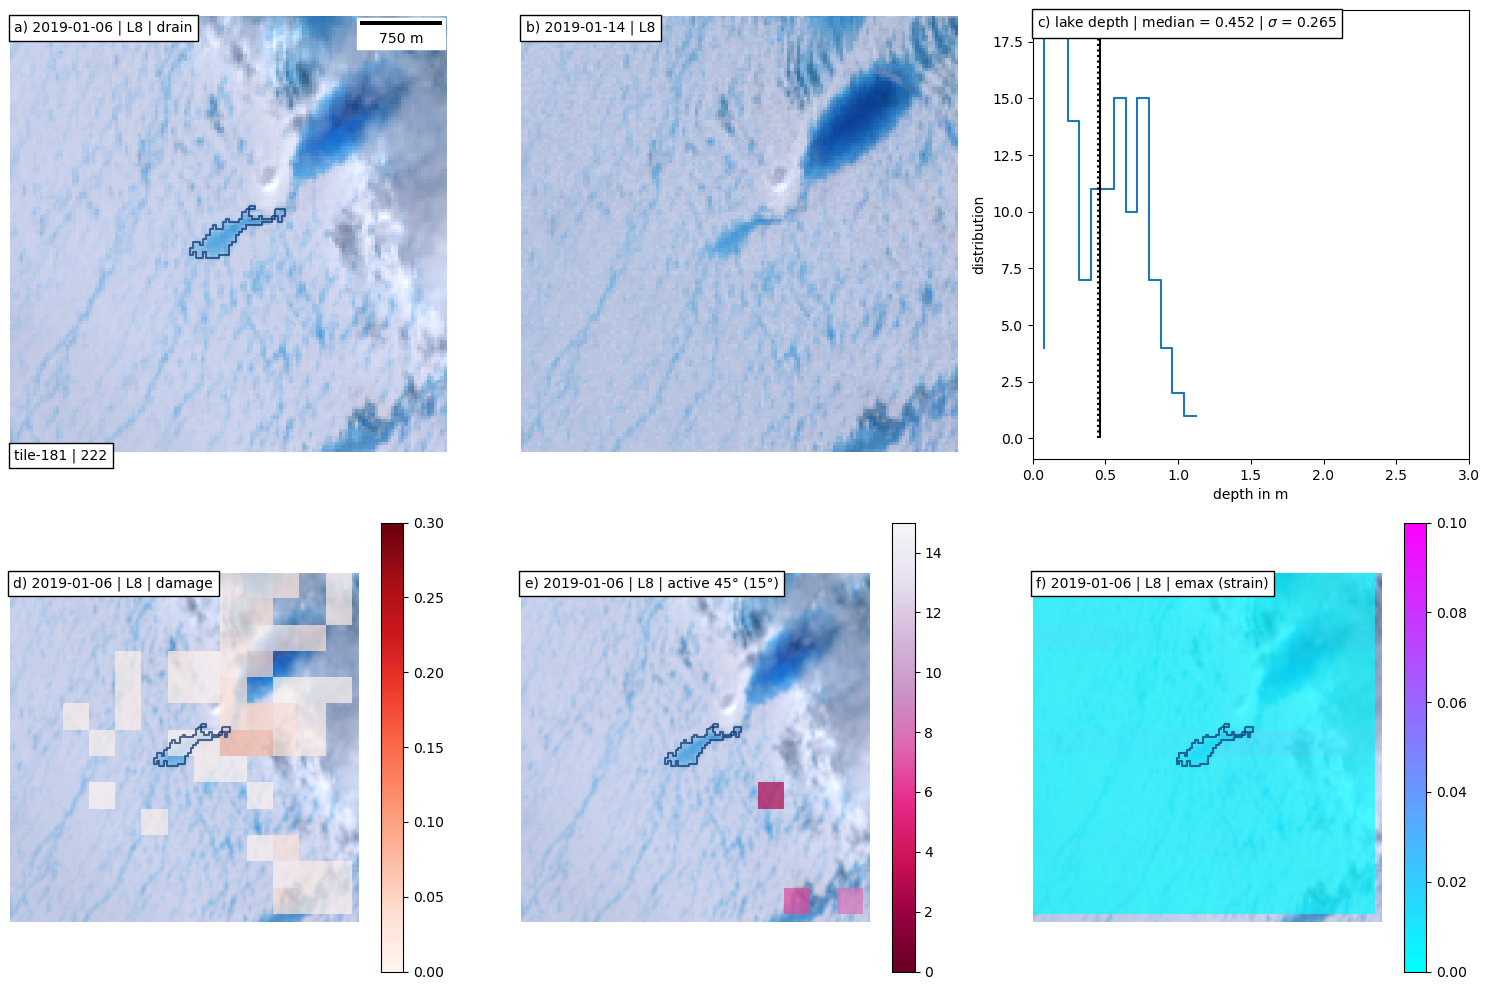

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


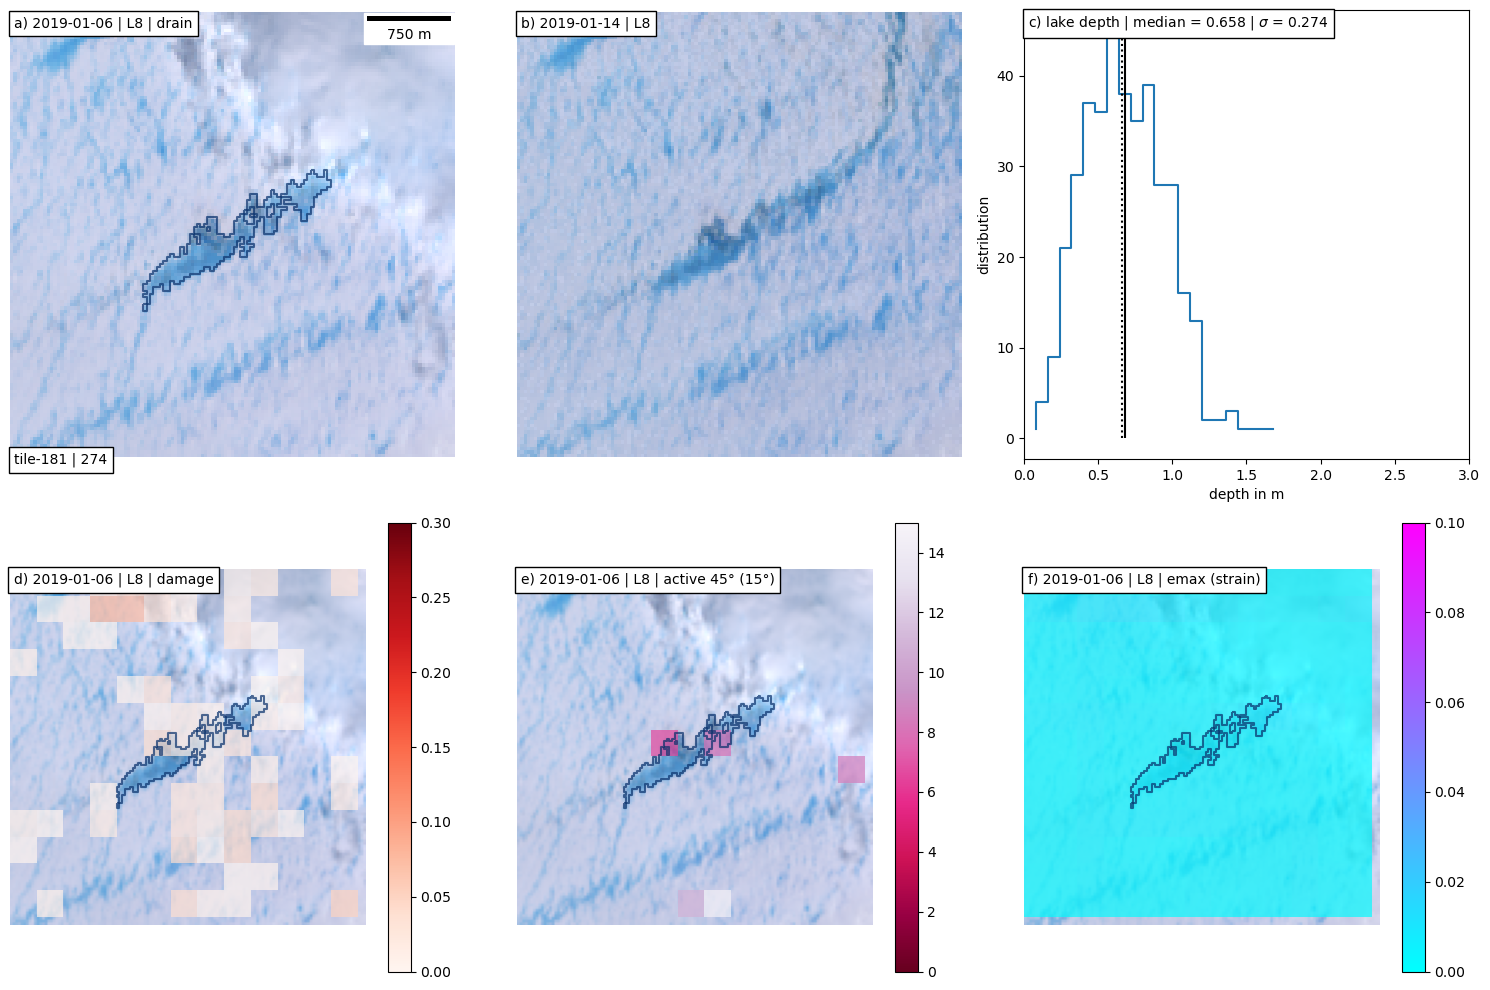

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


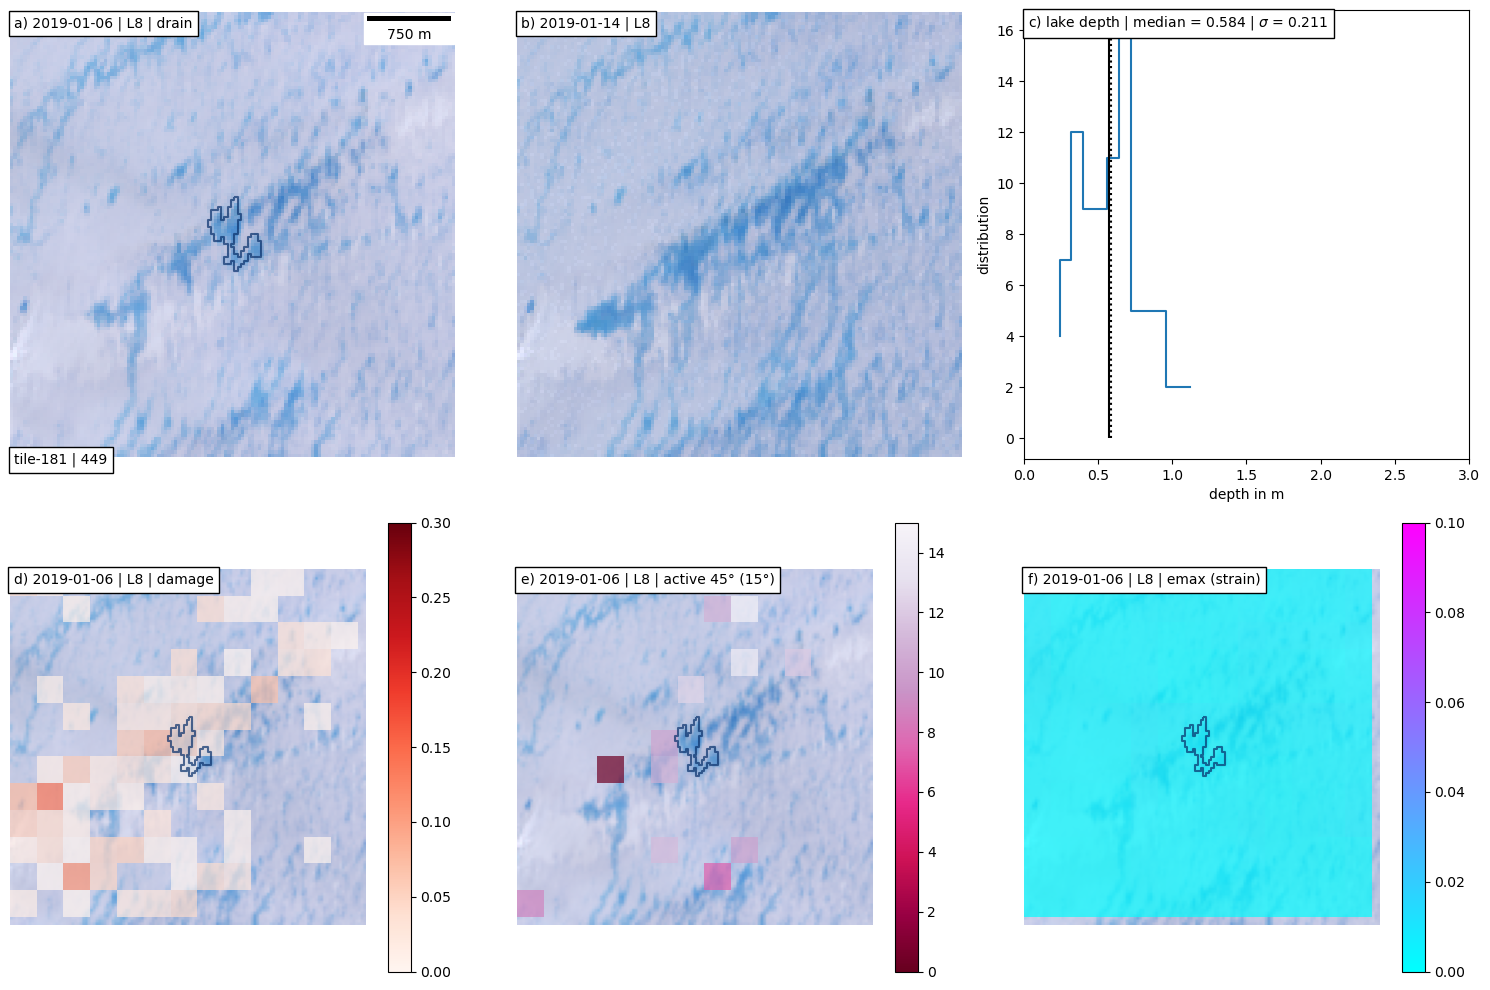

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


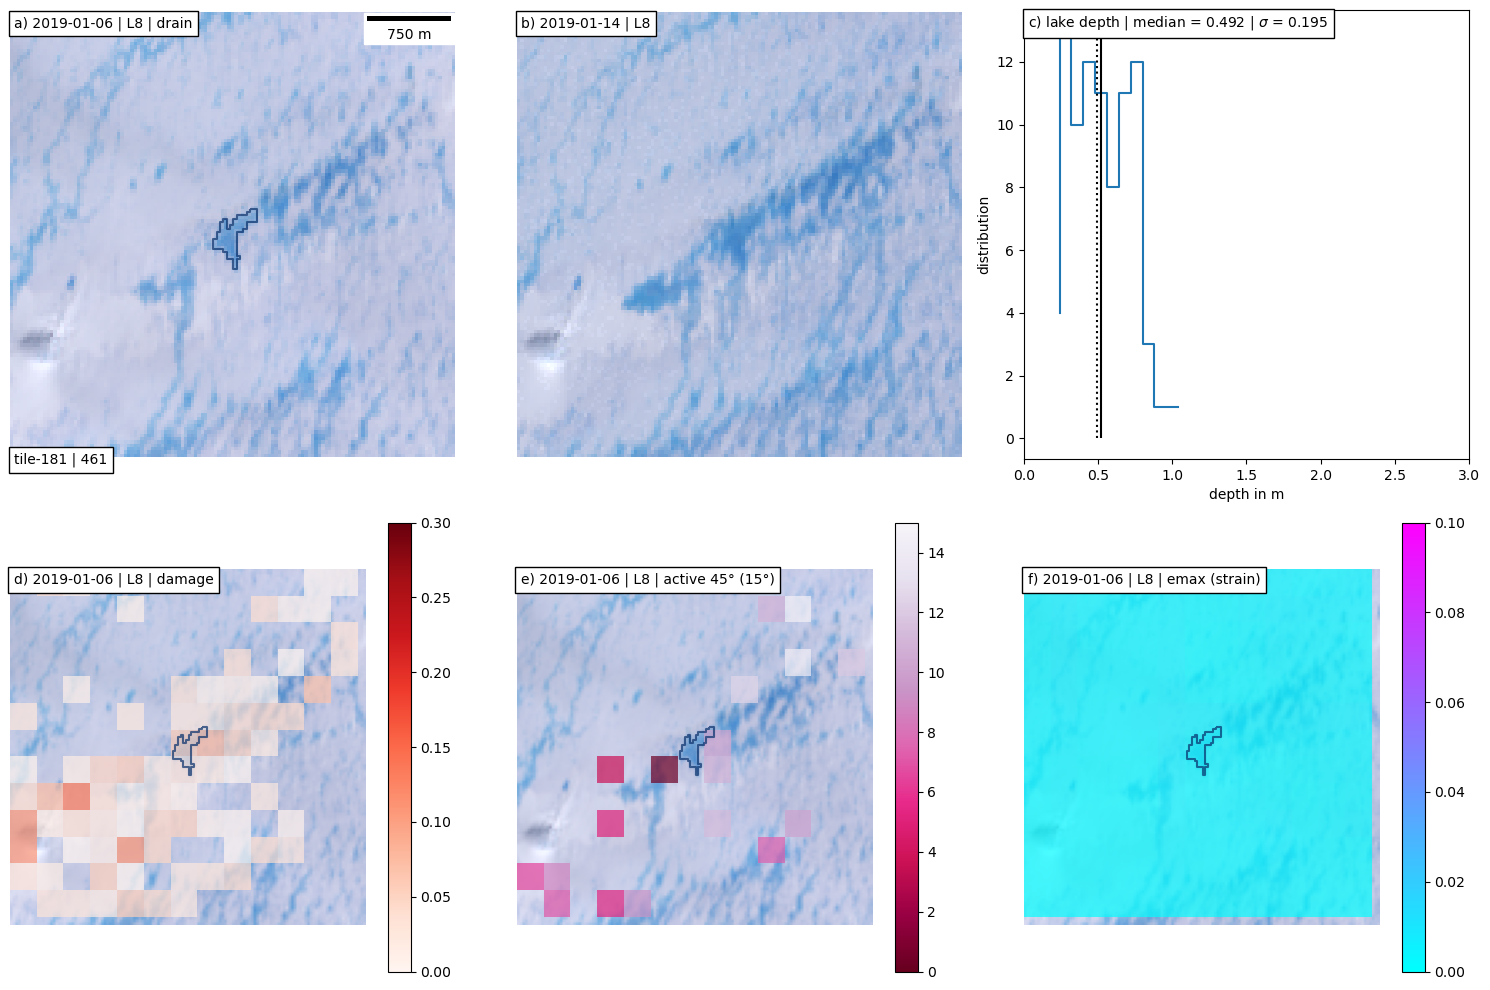

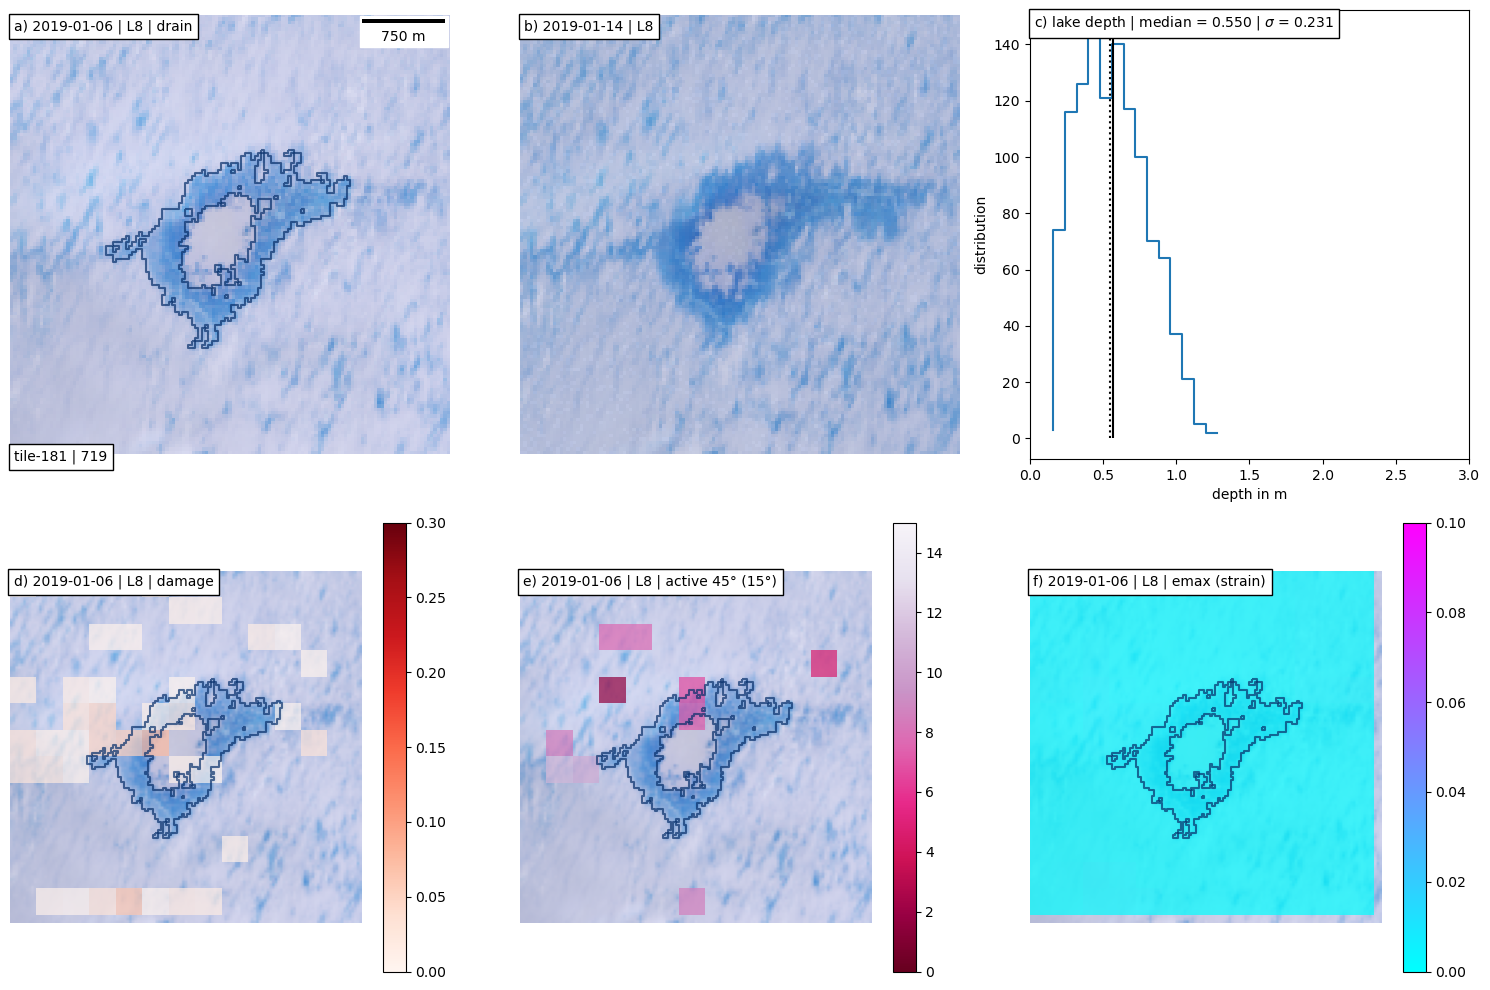

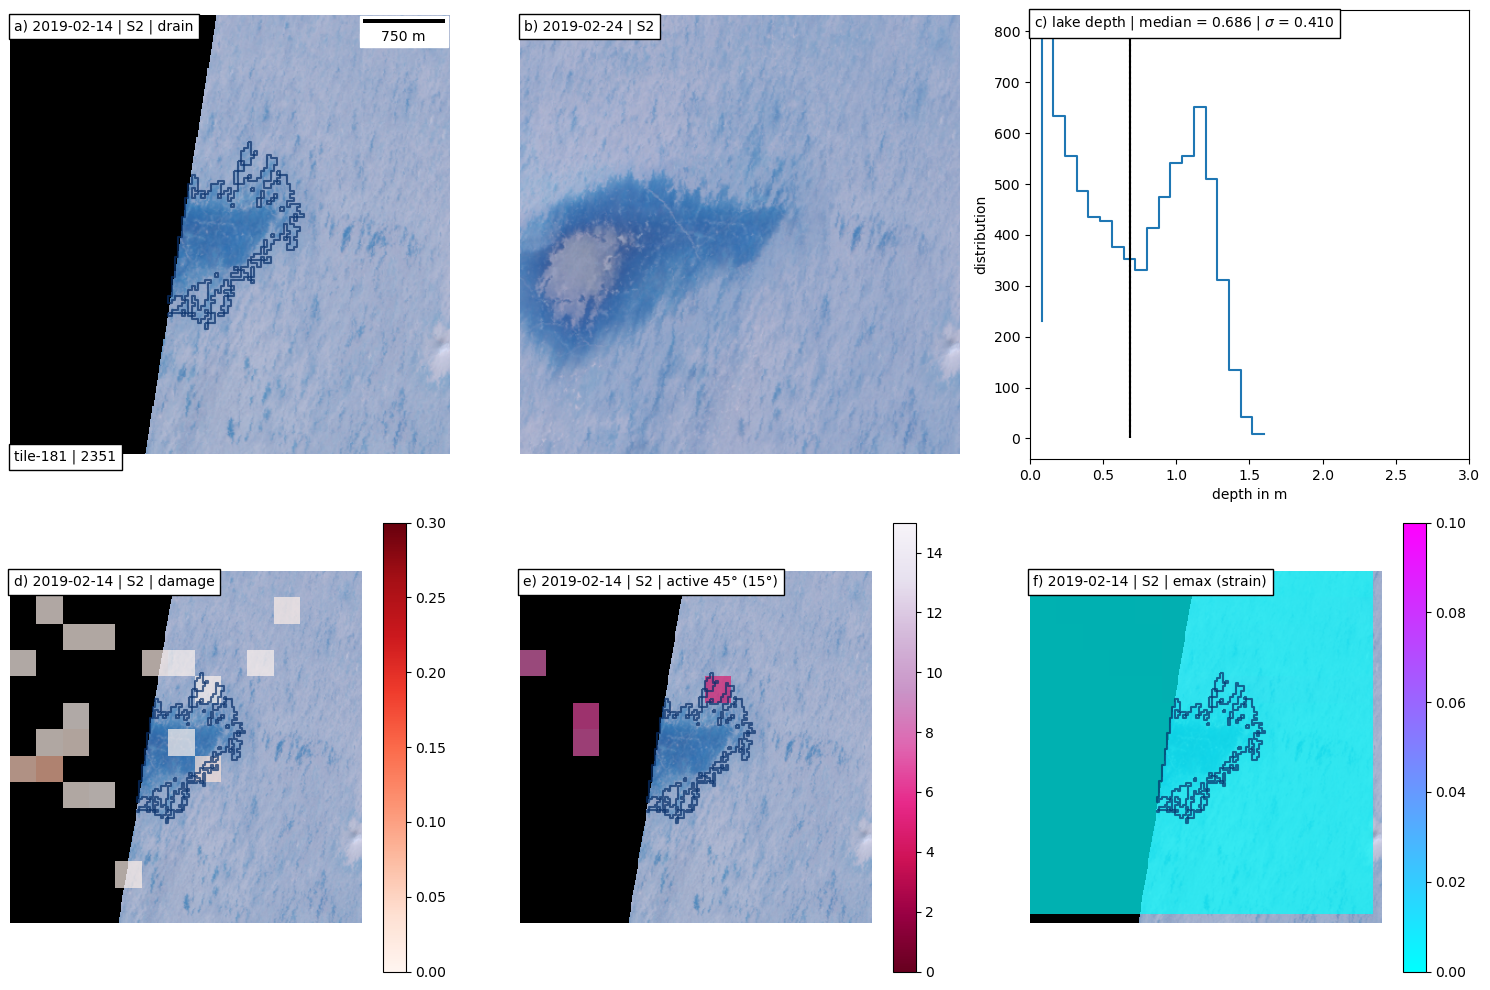

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


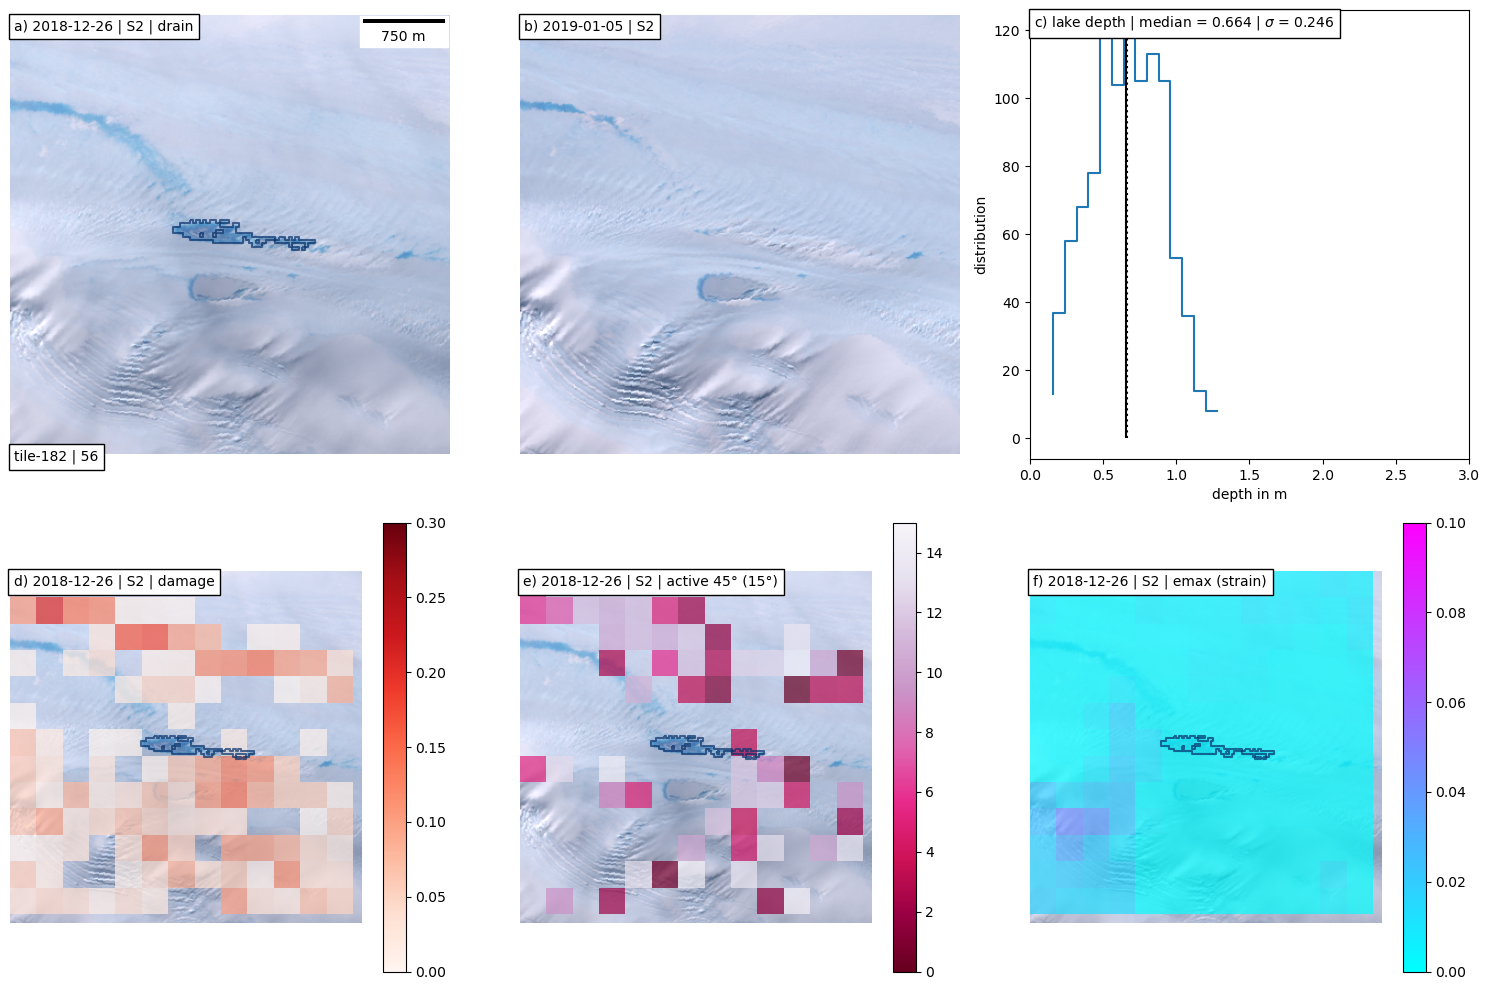

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


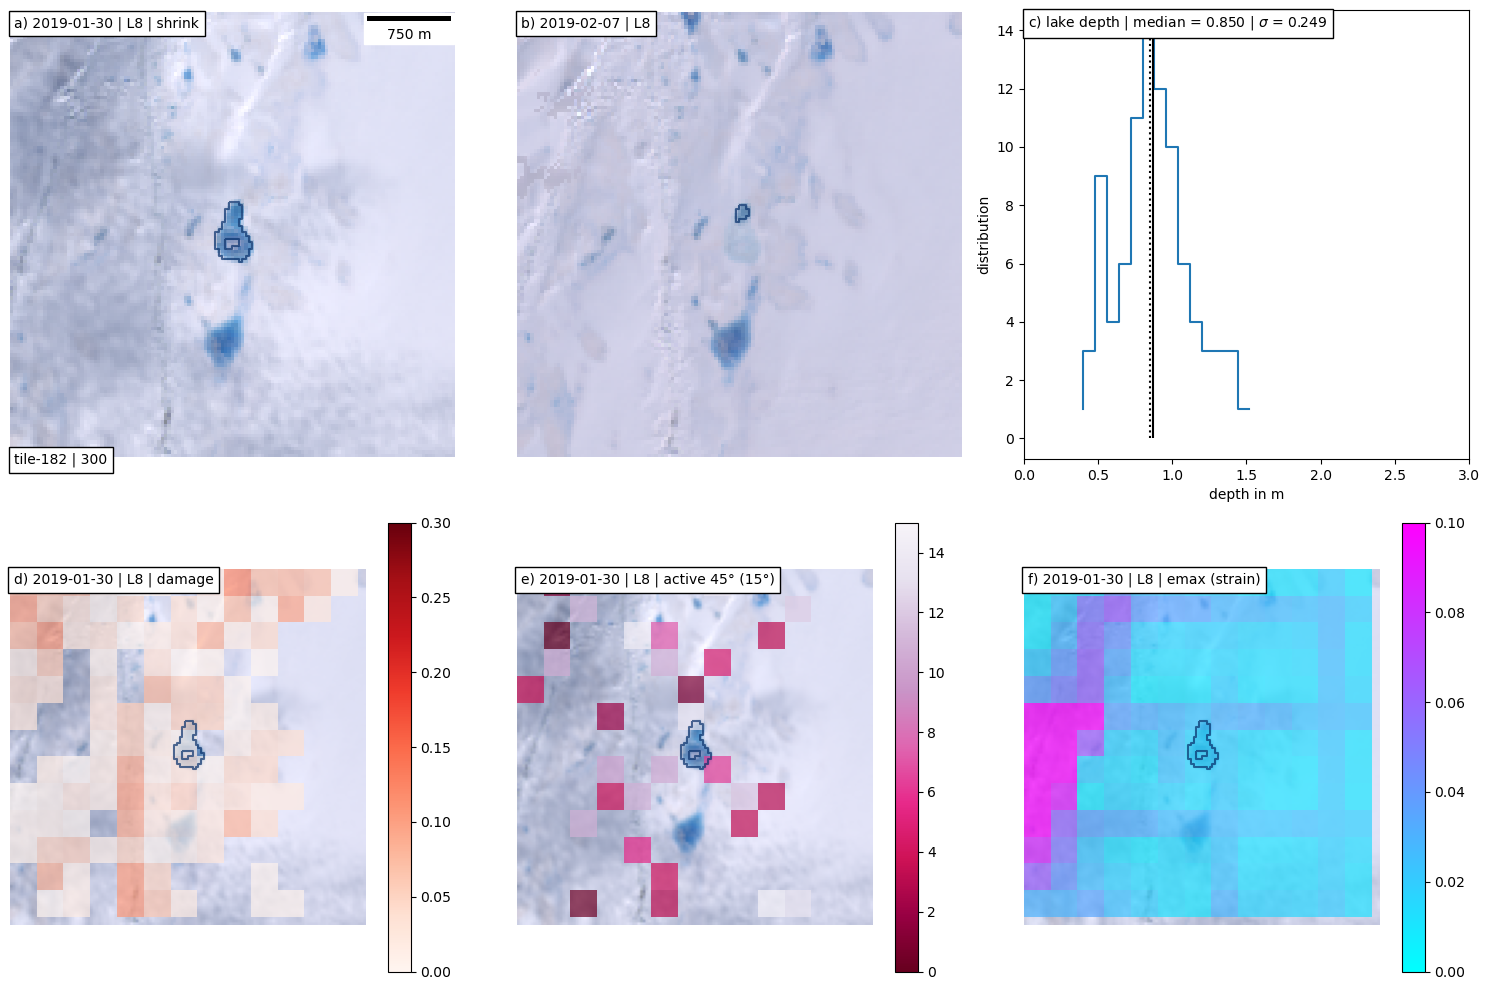

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


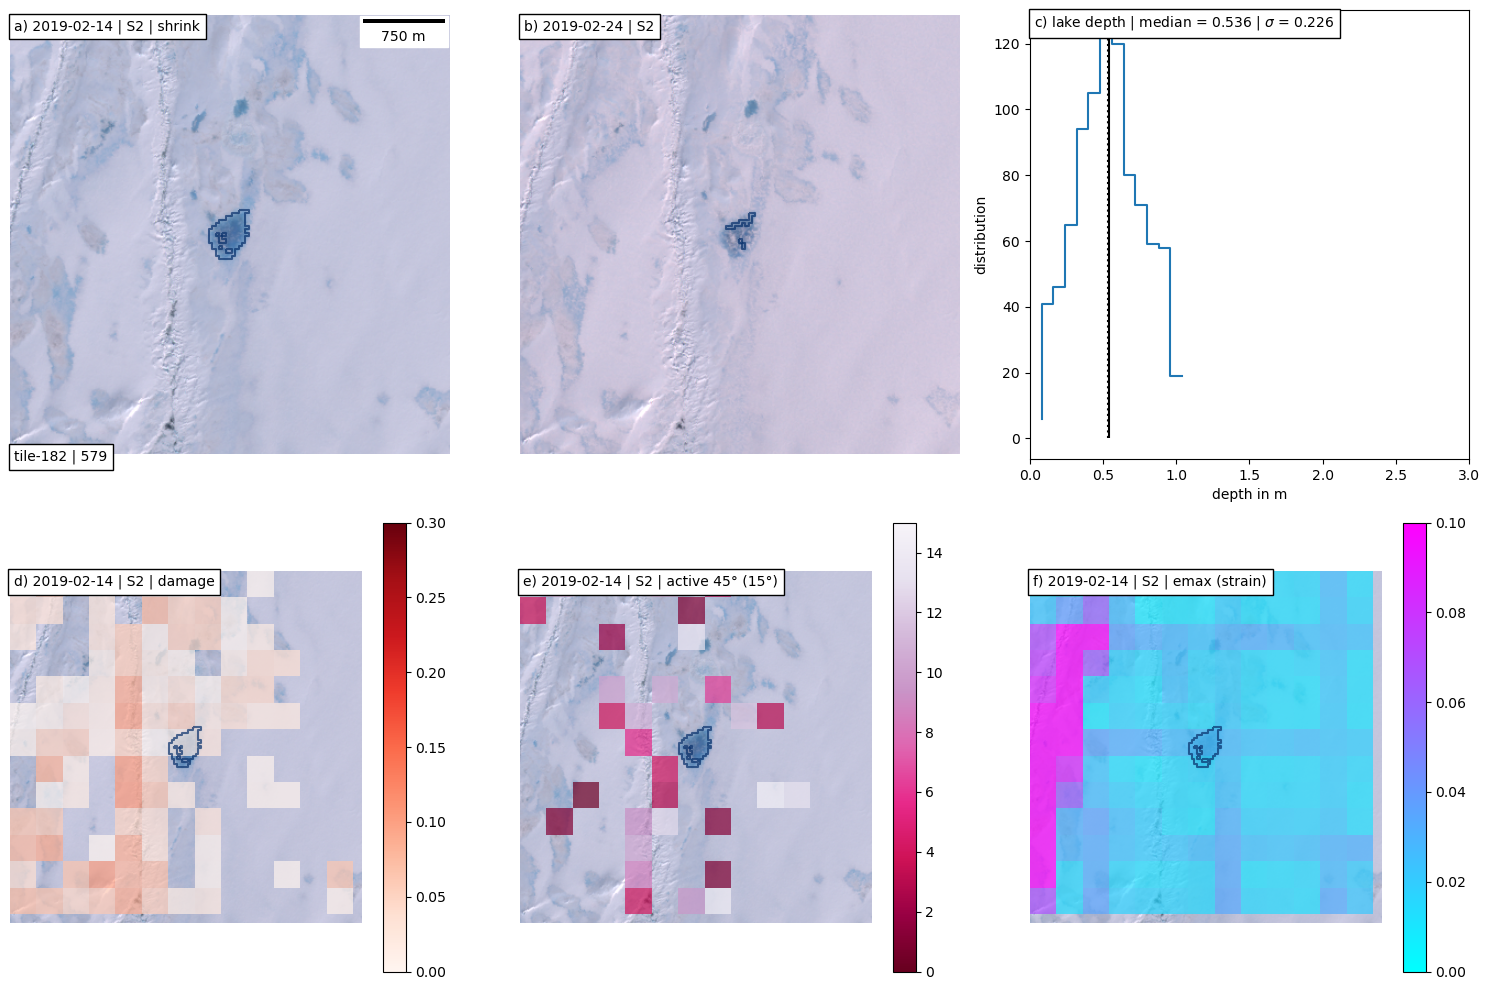

In [10]:
names = ["tile-181", "tile-182", "tile-183"]
offset = 2e3
max_imgs = 100
img_size = 5
max_depth = 3
save_fig = False

type = "positive"
settings = settings18
coll = coll18
#positive_drains = positive_drains19
drains = drains18

gdf_name = drains[drains["name"].isin(names)]
#for ilake, lake_criteria in enumerate(positive_drains):
for ilake, lake_criteria in enumerate(gdf_name[gdf_name["window"] == 0]["criteria"].unique()):
    gdf_lake = gdf_name[gdf_name["criteria"] == lake_criteria].reset_index()
    if gdf_lake.shape[0] == 0:
        continue
    w0 = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == gdf_lake["date-0"].iloc[0]][0]
    w1 = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == gdf_lake["date-1"].iloc[0]][0]

    lake0 = gdf_lake[gdf_lake["window"] == 0].dissolve()  # type: ignore
    minx = min(lake0.centroid.x) - offset
    miny = min(lake0.centroid.y) - offset
    maxx = max(lake0.centroid.x) + offset
    maxy = max(lake0.centroid.y) + offset
    print(minx, miny, maxx, maxy)
    dx = maxx - minx
    dy = maxy - miny

    with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
        rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb0_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
    with rasterio.open(os.path.join(settings.season_folder, w0.file_reduced)) as src:
        tif0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    
    with rasterio.open(os.path.join(settings.dmg_folder, w0.file_dmg)) as src:
        dmg = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        dmg_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
    
    with rasterio.open(os.path.join(settings.region_folder, w0.file_emax)) as src:
        emax = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        emax_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
        emax_res = np.reshape(emax, (emax.shape[0]*emax.shape[1], emax.shape[2]))
    
    with rasterio.open(os.path.join(settings.dmg_folder, w0.file_delta_alpha_c)) as src:
        delta_alpha_c = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        delta_alpha_c_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
        dmg_mask = np.zeros(dmg.shape)
        dmg_mask[dmg>0] = 1
        dmg_mask[np.nan_to_num(dmg, nan = 0)<=0] = np.nan
        d_alpha_masked = delta_alpha_c * dmg_mask
        active_crev = sgl_utils.create_active_crevasses_mask(d_alpha_masked, 45, 15)
        #active_crev[active_mask == 0] = np.nan

    with rasterio.open(os.path.join(settings.season_folder, w1.file_rgb)) as src:
        rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb1_transform = Affine(src.transform[0], src.transform[1], minx,
                            src.transform[3], src.transform[4], maxy)
    with rasterio.open(os.path.join(settings.season_folder, w1.file_reduced)) as src:
        tif1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    

    tif0_clipped, tif0_clipped_transform = sgl_utils.clip_dataset(tif0, rgb0_transform, coords = [geom for geom in lake0["geometry"]])
    depth0 = tif0_clipped[2]
    depth0[depth0 == 0] = np.nan
    tif1_clipped, tif1_clipped_transform = sgl_utils.clip_dataset(tif1, rgb1_transform, coords = [geom for geom in lake0["geometry"]])
    depth1 = tif1_clipped[2]
    depth1[depth1 == 0] = np.nan



    emax_base = plt.imshow(emax[0], cmap = "cool", vmin = 0, vmax = 0.1)
    dmg_base = plt.imshow(dmg[0], cmap = "Reds", vmin = 0, vmax = 0.3)
    active_crev_base = plt.imshow(active_crev[0], cmap = "PuRd_r", vmin = 0, vmax = 15)
    plt.close()



    fig, axes = plt.subplots(2, 3, figsize = (3 * img_size, 2 * img_size * dy / dx))
    axes_flat = np.ravel(np.array(axes))
    set_share_axes(axes_flat[0:2], sharex=True, sharey=True)
    set_share_axes(axes_flat[3:], sharex=True, sharey=True)
    
    ax = axes_flat[0]
    rplt.show(rgb0, transform = rgb0_transform, ax = ax)
    lake0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    #rplt.show(depth0, transform = tif0_clipped_transform, ax = ax)
    ax.text(.01, .99, "a) " + lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | " + lake0["type"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.text(.01, .01, lake0["name"].iloc[0] + " | " + str(int(lake0["lake id"].iloc[0])), ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.add_artist(ScaleBar(1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax= axes_flat[1]
    rplt.show(rgb1, transform = rgb1_transform, ax = ax)
    if lake0["type"].iloc[0]  == "shrink":
        lake1 = gdf_lake[gdf_lake["window"] == 1]
        lake1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, "b) " + lake0["date-1"].iloc[0] + " | " + lake0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax= axes_flat[2]
    bins = np.linspace(0, max_depth + 1, 51)
    depth0_digits = np.digitize(depth0, bins = bins)
    uniques, counts = np.unique(depth0_digits, return_counts = True)
    ax.step(uniques[:-1] * np.diff(bins)[0], counts[:-1])
    ax.vlines(x = np.nanmean(depth0), ymin = 0, ymax = counts[:-1].max(), label = "mean", color = "black")
    ax.vlines(x = np.nanmedian(depth0), ymin = 0, ymax = counts[:-1].max(), label = "median", color = "black", ls = ":")
    ax.set_xlabel("depth in m")
    ax.set_ylabel("distribution")
    ax.text(.01, .99, "c) lake depth" + " | median = " + f"{np.nanmedian(depth0):.3f} | "  + r"$\sigma$ = " + f"{np.nanstd(depth0):.3f}", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_xlim(0,max_depth)

    ax = axes_flat[3]
    rplt.show(rgb0, transform = rgb0_transform, ax = ax)
    rplt.show(dmg, transform = dmg_transform, ax = ax, cmap = "Reds", alpha = 0.7, vmin = 0, vmax = 0.3)
    lake0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, "d) " + lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | damage", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    fig.colorbar(dmg_base, ax=ax)

    ax = axes_flat[4]
    rplt.show(rgb0, transform = rgb0_transform, ax = ax)
    rplt.show(active_crev, transform = delta_alpha_c_transform, ax = ax, cmap = "PuRd_r", alpha = 0.7, vmin = 0, vmax = 15)
    lake0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, "e) " + lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | active 45° (15°)", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    fig.colorbar(active_crev_base, ax=ax)

    ax = axes_flat[5]
    
    rplt.show(rgb0, transform = rgb0_transform, ax = ax)
    retted = rplt.show(emax, transform = emax_transform, ax = ax, cmap = "cool", alpha = 0.7, vmin = 0, vmax = 0.15)
    lake0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, "f) " + lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | emax (strain)", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    fig.colorbar(emax_base, ax=ax)

    plt.tight_layout()
    if save_fig:
        fname_img = "_".join([type, lake0["name"].iloc[0], lake0["date-0"].iloc[0], str(int(lake0["lake id"].iloc[0])), lake0["date-1"].iloc[0], f"{w0.satellite}-{w1.satellite}", lake0["type"].iloc[0] + ".png"])
        fig.savefig(os.path.join(settings.img_folder, fname_img))
        plt.close()
    else:
        plt.show()

    if ilake >= max_imgs:
        break



[17, 57]

In [67]:
names = ["tile-181", "tile-182", "tile-183"]
offset = 2e3
max_imgs = 100
img_size = 3
max_depth = 3
save_fig = True

type = "positive"
settings = settings18
coll = coll18
positive_drains = positive_drains18
drains = drains18

gdf_name = drains[drains["name"].isin(names)]
for ilake, lake_criteria in enumerate(positive_drains):
#for ilake, lake_criteria in enumerate(gdf_name[gdf_name["window"] == 0]["criteria"].unique()):
    gdf_lake = gdf_name[gdf_name["criteria"] == lake_criteria].reset_index()
    if gdf_lake.shape[0] == 0:
        continue
    
    
    w0 = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == gdf_lake["date-0"].iloc[0]][0]
    w1 = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == gdf_lake["date-1"].iloc[0]][0]

    index_coll_criteria = coll.metadata.index[(coll.metadata['criteria'] == w0.metadata['criteria']) & (coll.metadata['name'] == w0.name)].tolist()[0]
    w1minus = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == coll.metadata.loc[index_coll_criteria - 1, "date"]][0]
    w2 = [w for w in coll.windows if w.name == gdf_lake["name"].iloc[0] and w.metadata["date"] == coll.metadata.loc[index_coll_criteria + 2, "date"]][0]


    lake0 = gdf_lake[gdf_lake["window"] == 0].dissolve()  # type: ignore
    minx = min(lake0.centroid.x) - offset
    miny = min(lake0.centroid.y) - offset
    maxx = max(lake0.centroid.x) + offset
    maxy = max(lake0.centroid.y) + offset
    dx = maxx - minx
    dy = maxy - miny

    with rasterio.open(os.path.join(settings.season_folder, w1minus.file_rgb)) as src:
        rgb1minus = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb1minus_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)

    with rasterio.open(os.path.join(settings.season_folder, w0.file_rgb)) as src:
        rgb0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb0_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
    with rasterio.open(os.path.join(settings.season_folder, w0.file_reduced)) as src:
        tif0 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    
    with rasterio.open(os.path.join(settings.dmg_folder, w0.file_dmg)) as src:
        dmg = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        dmg_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
    
    with rasterio.open(os.path.join(settings.region_folder, w0.file_emax)) as src:
        emax = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        emax_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
        emax_res = np.reshape(emax, (emax.shape[0]*emax.shape[1], emax.shape[2]))
    
    with rasterio.open(os.path.join(settings.dmg_folder, w0.file_delta_alpha_c)) as src:
        delta_alpha_c = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        delta_alpha_c_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
        dmg_mask = np.zeros(dmg.shape)
        dmg_mask[dmg>0] = 1
        dmg_mask[np.nan_to_num(dmg, nan = 0)<=0] = np.nan
        d_alpha_masked = delta_alpha_c * dmg_mask
        active_crev = sgl_utils.create_active_crevasses_mask(d_alpha_masked, 45, 15)
        #active_crev[active_mask == 0] = np.nan

    with rasterio.open(os.path.join(settings.season_folder, w1.file_rgb)) as src:
        rgb1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb1_transform = Affine(src.transform[0], src.transform[1], minx,
                            src.transform[3], src.transform[4], maxy)
    with rasterio.open(os.path.join(settings.season_folder, w1.file_reduced)) as src:
        tif1 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
    
    with rasterio.open(os.path.join(settings.season_folder, w2.file_rgb)) as src:
        rgb2 = src.read(window = rw.from_bounds(minx, miny, maxx, maxy, src.transform))
        rgb2_transform = Affine(src.transform[0], 0, minx,
                            0, src.transform[4], maxy)
    

    tif0_clipped, tif0_clipped_transform = sgl_utils.clip_dataset(tif0, rgb0_transform, coords = [geom for geom in lake0["geometry"]])
    depth0 = tif0_clipped[2]
    depth0[depth0 == 0] = np.nan
    tif1_clipped, tif1_clipped_transform = sgl_utils.clip_dataset(tif1, rgb1_transform, coords = [geom for geom in lake0["geometry"]])
    depth1 = tif1_clipped[2]
    depth1[depth1 == 0] = np.nan

    fig, axes = plt.subplots(1, 4, figsize = (4 * img_size, img_size * dy / dx), sharex=True, sharey=True)
    axes_flat = np.ravel(np.array(axes))
    
    ax = axes_flat[0]
    rplt.show(rgb1minus, transform = rgb1minus_transform, ax = ax)
    ax.text(.01, .99, w1minus.metadata["date"]  + " | " + lake0["sat-0"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.text(.01, .01, lake0["name"].iloc[0] + " | " + str(int(lake0["lake id"].iloc[0])), ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.add_artist(ScaleBar(1))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax = axes_flat[1]
    rplt.show(rgb0, transform = rgb0_transform, ax = ax)
    lake0.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, lake0["date-0"].iloc[0] + " | " + lake0["sat-0"].iloc[0] + " | " + lake0["type"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax= axes_flat[2]
    rplt.show(rgb1, transform = rgb1_transform, ax = ax)
    if lake0["type"].iloc[0]  == "shrink":
        lake1 = gdf_lake[gdf_lake["window"] == 1]
        lake1.boundary.plot(ax = ax, cmap = "Blues_r", alpha = 0.7)
    ax.text(.01, .99, lake0["date-1"].iloc[0] + " | " + lake0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    ax = axes_flat[3]
    rplt.show(rgb2, transform = rgb2_transform, ax = ax)
    ax.text(.01, .99, w2.metadata["date"]  + " | " + lake0["sat-1"].iloc[0], ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')

    plt.tight_layout()
    if save_fig:
        fname_img = "_".join([type, lake0["name"].iloc[0], lake0["date-0"].iloc[0], str(int(lake0["lake id"].iloc[0])), lake0["date-1"].iloc[0], f"{w0.satellite}-{w1.satellite}", lake0["type"].iloc[0] + "_series.png"])
        fig.savefig(os.path.join(settings.img_folder, fname_img))
        plt.close()
    else:
        plt.show()

    if ilake >= max_imgs:
        break



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
